In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/veerendra0201/ml-project


'https://jovian.ai/veerendra0201/ml-project'

# Don't get Kicked

One of the biggest challenges of an auto dealership purchasing a used car at an auto auction is the risk of that the vehicle might have serious issues that prevent it from being sold to customers. The auto community calls these unfortunate purchases "kicks".

Kicked cars often result when there are tampered odometers, mechanical issues the dealer is not able to address, issues with getting the vehicle title from the seller, or some other unforeseen problem. Kick cars can be very costly to dealers after transportation cost, throw-away repair work, and market losses in reselling the vehicle.

Modelers who can figure out which cars have a higher risk of being kick can provide real value to dealerships trying to provide the best inventory selection possible to their customers.

The challenge of this project is to make a model with maximum possible accuracy which predicts whether the car purchased at the Auction is a Kick (bad buy) or not.

> Let's start by installing and importing some important libraries..

In [2]:
!pip install pandas numpy matplotlib seaborn --quiet

In [3]:
!pip install opendatasets scikit-learn jovian --quiet --upgrade

     |████████████████████████████████| 24.8 MB 1.5 MB/s 


In [4]:
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import jovian
import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [5]:
train_df = pd.read_csv('training.csv')

In [6]:
train_df.shape

(72983, 34)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

## Data Description

RefID -> Unique (sequential) number assigned to vehicles

IsBadBuy -> Identifies if the kicked vehicle was an avoidable purchase

PurchDate -> The Date the vehicle was Purchased at Auction

Auction -> Auction provider at which the vehicle was purchased

VehYear -> The manufacturer's year of the vehicle

VehicleAge -> The Years elapsed since the manufacturer's year

Make -> Vehicle Manufacturer

Model -> Vehicle Model

Trim -> Vehicle Trim Level

SubModel -> Vehicle Submodel

Color -> Vehicle Color Transmission -> Vehicles transmission type (Automatic, Manual)

WheelTypeID -> The type id of the vehicle wheel

WheelType -> The vehicle wheel type description (Alloy, Covers)

VehOdo -> The vehicles odometer reading

Nationality -> The Manufacturer's country

Size -> The size category of the vehicle (Compact, SUV, etc.)

TopThreeAmericanName -> Identifies if the manufacturer is one of the top three American manufacturers MMRAcquisitionAuctionAveragePrice -> Acquisition price for this vehicle in average condition at time of purchase

MMRAcquisitionAuctionCleanPrice -> Acquisition price for this vehicle in the above Average condition at time of purchase

MMRAcquisitionRetailAveragePrice -> Acquisition price for this vehicle in the retail market in average condition at time of purchase

MMRAcquisitonRetailCleanPrice -> Acquisition price for this vehicle in the retail market in above average condition at time of purchase

MMRCurrentAuctionAveragePrice -> Acquisition price for this vehicle in average condition as of current day

MMRCurrentAuctionCleanPrice -> Acquisition price for this vehicle in the above condition as of current day

MMRCurrentRetailAveragePrice -> Acquisition price for this vehicle in the retail market in average condition as of current day

MMRCurrentRetailCleanPrice -> Acquisition price for this vehicle in the retail market in above average condition as of current day

PRIMEUNIT -> Identifies if the vehicle would have a higher demand than a standard purchase

AcquisitionType -> Identifies how the vehicle was aquired (Auction buy, trade in, etc)

AUCGUART -> The level guarntee provided by auction for the vehicle (Green light - Guaranteed/arbitratable, Yellow Light - caution/issue, red light - sold as is)

KickDate -> Date the vehicle was kicked back to the auction BYRNO -> Unique number assigned to the buyer that purchased the vehicle

VNZIP -> Zipcode where the car was purchased

VNST -> State where the the car was purchased

VehBCost -> Acquisition cost paid for the vehicle at time of purchase

IsOnlineSale -> Identifies if the vehicle was originally purchased online

WarrantyCost -> Warranty price (term=36month and millage=36K)

> PurchDate (Date of Purchase of car from auction) won't be any help in predicting if the car was a good or bad buy.
Similarly we don't have any use of RefId Column.
Also, BYRNO i.e. Unique number assigned to each buyer in auction is not useful as the buyer won't affect the quality of car.

In [7]:
train_df.drop(columns=["RefId", "PurchDate", "BYRNO"], inplace = True)

> The price diff at a above average conditioned vehicle won't be a much needed

In [8]:
train_df.drop(columns=["MMRCurrentRetailCleanPrice","MMRCurrentAuctionCleanPrice","MMRAcquisitionAuctionCleanPrice","MMRAcquisitonRetailCleanPrice"],inplace=True)

In [9]:
train_df.shape

(72983, 27)

> lets see how much the auction price and retail price differs by..

In [10]:
train_df["pricediff_before"]=train_df["MMRAcquisitionAuctionAveragePrice"]-train_df["MMRAcquisitionRetailAveragePrice"]
train_df["pricediff_after"]=train_df["MMRCurrentAuctionAveragePrice"]-train_df["MMRCurrentRetailAveragePrice"]
train_df.drop(columns=["MMRAcquisitionAuctionAveragePrice","MMRAcquisitionRetailAveragePrice","MMRCurrentAuctionAveragePrice","MMRCurrentRetailAveragePrice"],inplace=True)

### Visualizating Correlations

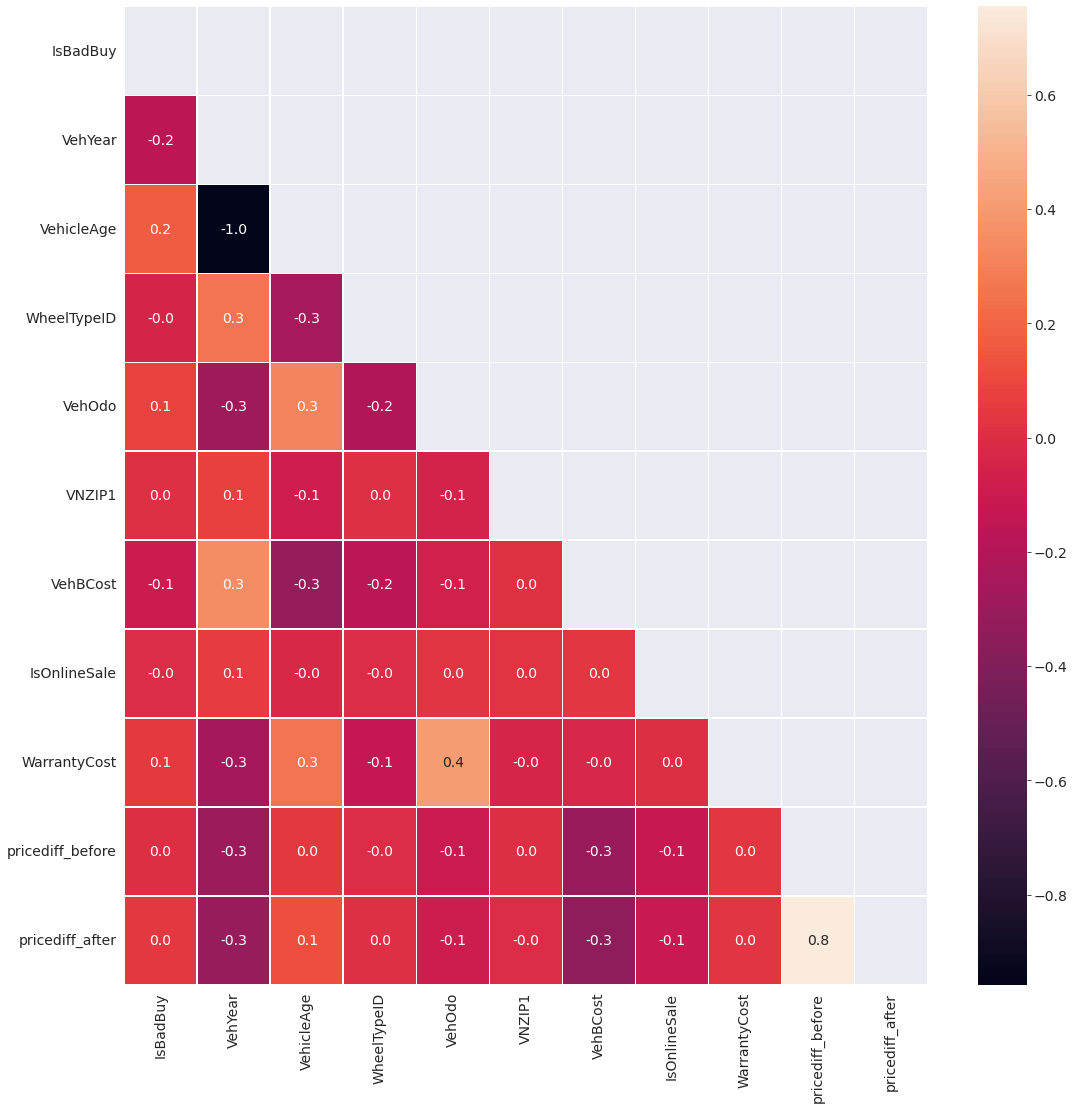

In [ ]:
plt.figure(figsize=(18, 18))
matrix = np.triu(train_df.corr())
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, fmt= '.1f', mask=matrix)
plt.show()

> From above figure we can see that VNZIP1 and WheelTypeID have no correlation with our target IsBadBuy. So we can safely drop them.



In [11]:
train_df.drop(columns = ["VNZIP1", "WheelTypeID",], inplace = True)

In [12]:
train_df.shape

(72983, 23)

### VehYear vs IsBadBuy

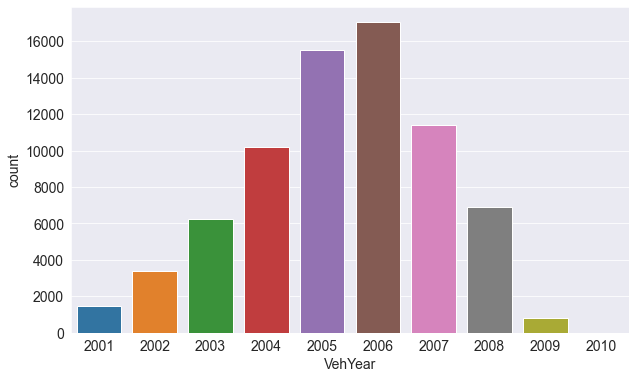

In [ ]:
sns.countplot(x = "VehYear", data = train_df);

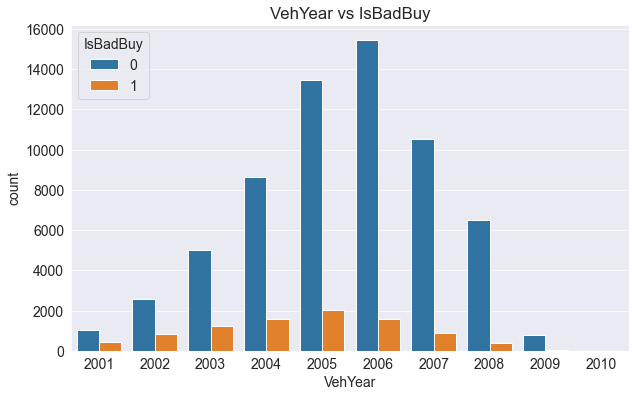

In [ ]:
plt.title('VehYear vs IsBadBuy')
sns.countplot(x = "VehYear", data = train_df, hue = "IsBadBuy");

> Nothing seems irrational. As the number of listings increased, so did the number of bad buys.

### VehicleAge vs IsBadBuy

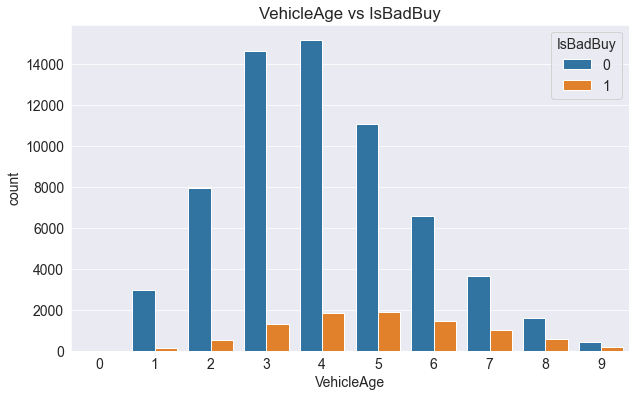

In [ ]:
plt.title('VehicleAge vs IsBadBuy')
sns.countplot(x = "VehicleAge", data = train_df, hue = "IsBadBuy");

### Auction vs IsBadBuy

> Let's install and import plotly library which is built on the top of matplotlib and seaborn for advanced visualizations.

In [13]:
!pip install plotly --quiet
import plotly.express as px

In [ ]:
px.histogram(train_df, x = "Auction", title='Auction vs IsBadBuy',color = "IsBadBuy")

### Make vs IsBadBuy

In [ ]:
px.histogram(train_df, x = "Make",title = 'Make vs IsBadBuy',color = "IsBadBuy")

> Dogde, Ford, Chevrolet and Chrysler cars account for the most listed as well as most bad buys. That makes sense. If a company has more listings, it will as well have higher bad buys.

In [ ]:
px.histogram(train_df, x = "Nationality",title='Nationality vs IsBadBuy', color = "IsBadBuy")

In [14]:
other_asian = len(train_df[(train_df['Nationality']=="OTHER ASIAN") & train_df["IsBadBuy"]==1])*100/len(train_df[train_df['Nationality']=="OTHER ASIAN"])
american = len(train_df[(train_df['Nationality']=="AMERICAN") & train_df["IsBadBuy"]==1])*100/len(train_df[train_df['Nationality']=="AMERICAN"])
top_line_asian = len(train_df[(train_df['Nationality']=="TOP LINE ASIAN") & train_df["IsBadBuy"]==1])*100/len(train_df[train_df['Nationality']=="TOP LINE ASIAN"])
other = len(train_df[(train_df['Nationality']=="OTHER") & train_df["IsBadBuy"]==1])*100/len(train_df[train_df['Nationality']=="OTHER"])

print(f"OTHER ASIAN: {round(other_asian)}%")
print(f"AMERICAN: {round(american)}%")
print(f"TOP LINE ASIAN: {round(top_line_asian)}%")
print(f"OTHER: {round(other)}%")

OTHER ASIAN: 13%
AMERICAN: 12%
TOP LINE ASIAN: 13%
OTHER: 14%


> Above values indicate percentage of badbuy in different nations

## Missing values

> Let's see the percentage of missing values in each column..

In [15]:
train_df.isna().sum()*100 / len(train_df)

IsBadBuy                 0.000000
Auction                  0.000000
VehYear                  0.000000
VehicleAge               0.000000
Make                     0.000000
Model                    0.000000
Trim                     3.233630
SubModel                 0.010961
Color                    0.010961
Transmission             0.012332
WheelType                4.348958
VehOdo                   0.000000
Nationality              0.006851
Size                     0.006851
TopThreeAmericanName     0.006851
PRIMEUNIT               95.315347
AUCGUART                95.315347
VNST                     0.000000
VehBCost                 0.000000
IsOnlineSale             0.000000
WarrantyCost             0.000000
pricediff_before         0.024663
pricediff_after          0.431607
dtype: float64

> Though PRIMEUNIT and AUCGUART has 95% of missing values .. these columns posses special value .
Since TopThreeAmericanName column can't give much information about quality of the car, let's just drop these columns

In [16]:
train_df.drop(columns = [ "TopThreeAmericanName"], inplace = True)

> Let's separate the columns in training dataset on the basis of dtypes as numeric columns and categorical columns.

In [17]:
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_df.select_dtypes('object').columns.tolist()

In [18]:
numeric_cols

['IsBadBuy',
 'VehYear',
 'VehicleAge',
 'VehOdo',
 'VehBCost',
 'IsOnlineSale',
 'WarrantyCost',
 'pricediff_before',
 'pricediff_after']

### Inputing missing values

> Now let's inpute the missinig values by importing `SimpleImputer` from `sklearn.impute`.

`SimpleImputer fills all the missing values or Nan values with averages of respective columns.`

In [19]:
from sklearn.impute import SimpleImputer

In [20]:
imputer = SimpleImputer(strategy = 'mean')

In [21]:
train_df[numeric_cols].isna().sum()

IsBadBuy              0
VehYear               0
VehicleAge            0
VehOdo                0
VehBCost              0
IsOnlineSale          0
WarrantyCost          0
pricediff_before     18
pricediff_after     315
dtype: int64

In [22]:
imputer.fit(train_df[numeric_cols])

SimpleImputer()

> After calling fit, the computed statistic for each column is stored in the statistics_ property of imputer.

In [23]:
list(imputer.statistics_)

[0.12298754504473644,
 2005.3430524916762,
 4.176643875971116,
 71499.99591685736,
 6730.934326212955,
 0.025279859693353248,
 1276.580984612855,
 -2368.1251147810594,
 -2643.6420432652612]

> The missing values in the training and test sets can now be filled in using the transform method of imputer.

In [24]:
train_df[numeric_cols] = imputer.transform(train_df[numeric_cols])

In [25]:
train_df[numeric_cols].isna().sum()

IsBadBuy            0
VehYear             0
VehicleAge          0
VehOdo              0
VehBCost            0
IsOnlineSale        0
WarrantyCost        0
pricediff_before    0
pricediff_after     0
dtype: int64

### Scaling Numeric Features

In [26]:
train_df[numeric_cols].describe()

,IsBadBuy,VehYear,VehicleAge,VehOdo,VehBCost,IsOnlineSale,WarrantyCost,pricediff_before,pricediff_after
count,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000
mean,0.122988,2005.343052,4.176644,71499.995917,6730.934326,0.025280,1276.580985,-2368.125115,-2643.642043
std,0.328425,1.731252,1.712210,14578.913128,1767.846435,0.156975,598.846788,1369.028057,1304.305836
min,0.000000,2001.000000,0.000000,4825.000000,1.000000,0.000000,462.000000,-7731.000000,-7460.000000
25%,0.000000,2004.000000,3.000000,61837.000000,5435.000000,0.000000,837.000000,-3565.000000,-3644.000000
50%,0.000000,2005.000000,4.000000,73361.000000,6700.000000,0.000000,1155.000000,-2851.000000,-3161.000000
75%,0.000000,2007.000000,5.000000,82436.000000,7900.000000,0.000000,1623.000000,-983.000000,-1084.000000
max,1.000000,2010.000000,9.000000,115717.000000,45469.000000,1.000000,7498.000000,0.000000,40.000000


> Since the parameters will be in different ranges, scaling is done so that one parameter doesn't effect other parameter. 
`Let's use MinMaxScaler from sklearn.preprocessing to scale values to the ( 0 , 1 ) range.`

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
scaler = MinMaxScaler()

> IsBadBuy is the output column . so we shouldn't scale that column

In [29]:
req_col=numeric_cols[1:].copy()

In [30]:
req_col

['VehYear',
 'VehicleAge',
 'VehOdo',
 'VehBCost',
 'IsOnlineSale',
 'WarrantyCost',
 'pricediff_before',
 'pricediff_after']

In [31]:
scaler.fit(train_df[req_col])

MinMaxScaler()

In [32]:
train_df[req_col] = scaler.transform(train_df[req_col])

## Categorical Data

### Auction

In [34]:
categorical_cols

['Auction',
 'Make',
 'Model',
 'Trim',
 'SubModel',
 'Color',
 'Transmission',
 'WheelType',
 'Nationality',
 'Size',
 'PRIMEUNIT',
 'AUCGUART',
 'VNST']

In [35]:
train_df[categorical_cols].Auction.nunique()

3

In [36]:
train_df[categorical_cols].Auction.unique()

array(['ADESA', 'OTHER', 'MANHEIM'], dtype=object)

### PrimeUnit

In [37]:
train_df.PRIMEUNIT.unique()

array([nan, 'NO', 'YES'], dtype=object)

In [38]:
train_df.PRIMEUNIT = train_df.PRIMEUNIT.fillna("other")

> Primeunit is a special aspect given to some special vehicles to increase their worth , so we should it into consideration by changing all nan to others

In [39]:
train_df.PRIMEUNIT.unique()

array(['other', 'NO', 'YES'], dtype=object)

### AUCGUART

In [40]:
train_df.AUCGUART.unique()

array([nan, 'GREEN', 'RED'], dtype=object)

In [41]:
train_df.AUCGUART=train_df.AUCGUART.fillna("other")

In [42]:
train_df.AUCGUART.unique()

array(['other', 'GREEN', 'RED'], dtype=object)

### Make

In [43]:
train_df[categorical_cols].Make.nunique()

33

In [44]:
train_df[categorical_cols].Make.unique()

array(['MAZDA', 'DODGE', 'FORD', 'MITSUBISHI', 'KIA', 'GMC', 'NISSAN',
       'CHEVROLET', 'SATURN', 'CHRYSLER', 'MERCURY', 'HYUNDAI', 'TOYOTA',
       'PONTIAC', 'SUZUKI', 'JEEP', 'HONDA', 'OLDSMOBILE', 'BUICK',
       'SCION', 'VOLKSWAGEN', 'ISUZU', 'LINCOLN', 'MINI', 'SUBARU',
       'CADILLAC', 'VOLVO', 'INFINITI', 'PLYMOUTH', 'LEXUS', 'ACURA',
       'TOYOTA SCION', 'HUMMER'], dtype=object)

### Model

In [45]:
train_df[categorical_cols].Model.nunique()

1063

*As this column contains much many unique vales .. they add too many columns while encoding which bring some effects on the model .. so lets drop it and submodel too*

In [46]:
train_df.drop(columns=["Model","SubModel"],inplace=True)
categorical_cols.remove("Model")

In [47]:
categorical_cols.remove("SubModel")

### Transmission

In [48]:
train_df[categorical_cols].Transmission.nunique()

3

In [49]:
train_df[categorical_cols].Transmission.unique()

array(['AUTO', 'MANUAL', nan, 'Manual'], dtype=object)

> Let's drop the rows with nan values and correct the naming error in Manual to MANUAL.

In [50]:
train_df.Transmission.replace(to_replace='Manual', value = "MANUAL", inplace = True)

In [51]:
train_df.dropna(subset=['Transmission'],inplace = True)

In [52]:
train_df[categorical_cols].Transmission.unique()

array(['AUTO', 'MANUAL'], dtype=object)

### Nationality

In [53]:
train_df[categorical_cols].Nationality.nunique()

4

In [54]:
train_df[categorical_cols].Nationality.unique()

array(['OTHER ASIAN', 'AMERICAN', 'TOP LINE ASIAN', 'OTHER', nan],
      dtype=object)

*Let's merge OTHER ASIAN and TOP LINE ASIAN into a single ASIAN category. This will make more sense.*

In [55]:
train_df.Nationality.replace(to_replace=["OTHER ASIAN", "TOP LINE ASIAN"], value = "ASIAN", inplace = True)

In [56]:
train_df.dropna(subset = ['Nationality'],inplace = True)

In [57]:
train_df.Nationality.unique()

array(['ASIAN', 'AMERICAN', 'OTHER'], dtype=object)

### Size

In [58]:
train_df[categorical_cols].Size.nunique()

12

In [59]:
train_df[categorical_cols].Size.unique()

array(['MEDIUM', 'LARGE TRUCK', 'COMPACT', 'LARGE', 'VAN', 'MEDIUM SUV',
       'LARGE SUV', 'SPECIALTY', 'SPORTS', 'CROSSOVER', 'SMALL SUV',
       'SMALL TRUCK'], dtype=object)

### VNST

In [60]:
train_df[categorical_cols].VNST.nunique()

37

In [61]:
train_df[categorical_cols].VNST.unique()

array(['FL', 'VA', 'IA', 'AR', 'MN', 'TN', 'PA', 'OH', 'AL', 'MI', 'TX',
       'IL', 'MA', 'AZ', 'GA', 'NC', 'MD', 'CA', 'UT', 'OR', 'SC', 'CO',
       'ID', 'NV', 'WV', 'MS', 'OK', 'NM', 'LA', 'IN', 'MO', 'WA', 'NH',
       'NJ', 'NY', 'NE', 'KY'], dtype=object)

In [62]:
col=list(train_df.columns)
for ele in col:
  print(train_df[ele].unique())

[0. 1.]
['ADESA' 'OTHER' 'MANHEIM']
[0.55555556 0.33333333 0.44444444 0.66666667 0.         0.22222222
 0.11111111 0.77777778 0.88888889 1.        ]
[0.33333333 0.55555556 0.44444444 0.22222222 0.88888889 0.66666667
 0.77777778 1.         0.11111111 0.        ]
['MAZDA' 'DODGE' 'FORD' 'MITSUBISHI' 'KIA' 'GMC' 'NISSAN' 'CHEVROLET'
 'SATURN' 'CHRYSLER' 'MERCURY' 'HYUNDAI' 'TOYOTA' 'PONTIAC' 'SUZUKI'
 'JEEP' 'HONDA' 'OLDSMOBILE' 'BUICK' 'SCION' 'VOLKSWAGEN' 'ISUZU'
 'LINCOLN' 'MINI' 'SUBARU' 'CADILLAC' 'VOLVO' 'INFINITI' 'PLYMOUTH'
 'LEXUS' 'ACURA' 'TOYOTA SCION' 'HUMMER']
['i' 'ST' 'SXT' 'ZX3' 'ES' 'EX' 'SE' 'SEL' 'SLE' 'XL' 'Bas' 'LS' nan 'SS'
 'SLT' '150' 'Spo' 'LX' 'GLS' 'CE' 'GT' 'Lar' '2' 'Adv' 'SR5' 'GXP' 'Tou'
 'XLT' 'LT' 'SES' 'XLS' 'GL' 'LE' '1' 'L20' 'Lim' 's' 'Edd' '3' 'Edg'
 'ZTW' 'ZX4' 'STX' 'CX' 'Nor' 'GS' 'XE' 'CXL' 'Ren' 'LTZ' 'ZTS' 'S' 'GTC'
 'GTP' 'Cla' 'Spy' 'LXi' 'SE-' 'Exe' 'Pre' 'SL2' 'GXE' 'SL1' 'Cus' 'GLE'
 'DE' 'Z71' 'Si' 'X' 'SX' 'XR' 'SVT' 'GTS' 'LW3' 'SV6' 'Va

### Trim

In [63]:
train_df["Trim"].unique()

array(['i', 'ST', 'SXT', 'ZX3', 'ES', 'EX', 'SE', 'SEL', 'SLE', 'XL',
       'Bas', 'LS', nan, 'SS', 'SLT', '150', 'Spo', 'LX', 'GLS', 'CE',
       'GT', 'Lar', '2', 'Adv', 'SR5', 'GXP', 'Tou', 'XLT', 'LT', 'SES',
       'XLS', 'GL', 'LE', '1', 'L20', 'Lim', 's', 'Edd', '3', 'Edg',
       'ZTW', 'ZX4', 'STX', 'CX', 'Nor', 'GS', 'XE', 'CXL', 'Ren', 'LTZ',
       'ZTS', 'S', 'GTC', 'GTP', 'Cla', 'Spy', 'LXi', 'SE-', 'Exe', 'Pre',
       'SL2', 'GXE', 'SL1', 'Cus', 'GLE', 'DE', 'Z71', 'Si', 'X', 'SX',
       'XR', 'SVT', 'GTS', 'LW3', 'SV6', 'Val', 'Car', 'eL', 'DX', 'Spe',
       'W/T', 'LW2', 'Pro', 'SL', 'L30', 'RT', 'CXS', 'VP', 'Cin', 'Max',
       'Ral', 'Sta', 'Lux', 'R/T', 'Her', 'ZX5', 'Xsp', 'Kin', '3 R',
       'Hig', 'GX', 'EX-', 'RS', 'Plu', 'Ult', 'DS', 'Ove', 'Den', 'XRS',
       'SC2', 'Sig', 'SC1', 'XS', 'C', 'ZX2', 'ZXW', 'ZR2', 'Dur', 'OZ',
       'L', '250', 'eC', 'FX4', 'Out', 'L10', 'Maz', 'Ent', 'T5', 'Z24',
       'Har', 'LL', 'Hyb', 'JLX', 'JLS', 'L 3'], dtype=obj

In [64]:
train_df.drop(columns="Trim",inplace=True)
categorical_cols.remove("Trim")

### Color and WheelType

In [65]:
train_df["Color"].unique()

array(['RED', 'WHITE', 'MAROON', 'SILVER', 'BLACK', 'GOLD', 'GREY',
       'BLUE', 'BEIGE', 'PURPLE', 'ORANGE', 'GREEN', 'BROWN', 'YELLOW',
       'NOT AVAIL', 'OTHER'], dtype=object)

In [66]:
train_df["WheelType"].unique()

array(['Alloy', 'Covers', nan, 'Special'], dtype=object)

In [67]:
train_df.WheelType = train_df.WheelType.fillna("other")

## Encoding Categorical Cols

In [68]:
train_df[categorical_cols].nunique()

Auction          3
Make            33
Color           16
Transmission     2
WheelType        4
Nationality      3
Size            12
PRIMEUNIT        3
AUCGUART         3
VNST            37
dtype: int64

In [69]:
from sklearn.preprocessing import OneHotEncoder

In [70]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [71]:
encoder.fit(train_df[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [72]:
encoder.categories_

[array(['ADESA', 'MANHEIM', 'OTHER'], dtype=object),
 array(['ACURA', 'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE',
        'FORD', 'GMC', 'HONDA', 'HUMMER', 'HYUNDAI', 'INFINITI', 'ISUZU',
        'JEEP', 'KIA', 'LEXUS', 'LINCOLN', 'MAZDA', 'MERCURY', 'MINI',
        'MITSUBISHI', 'NISSAN', 'OLDSMOBILE', 'PLYMOUTH', 'PONTIAC',
        'SATURN', 'SCION', 'SUBARU', 'SUZUKI', 'TOYOTA', 'TOYOTA SCION',
        'VOLKSWAGEN', 'VOLVO'], dtype=object),
 array(['BEIGE', 'BLACK', 'BLUE', 'BROWN', 'GOLD', 'GREEN', 'GREY',
        'MAROON', 'NOT AVAIL', 'ORANGE', 'OTHER', 'PURPLE', 'RED',
        'SILVER', 'WHITE', 'YELLOW'], dtype=object),
 array(['AUTO', 'MANUAL'], dtype=object),
 array(['Alloy', 'Covers', 'Special', 'other'], dtype=object),
 array(['AMERICAN', 'ASIAN', 'OTHER'], dtype=object),
 array(['COMPACT', 'CROSSOVER', 'LARGE', 'LARGE SUV', 'LARGE TRUCK',
        'MEDIUM', 'MEDIUM SUV', 'SMALL SUV', 'SMALL TRUCK', 'SPECIALTY',
        'SPORTS', 'VAN'], dtype=object),
 array(['NO

In [73]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Auction_ADESA', 'Auction_MANHEIM', 'Auction_OTHER', 'Make_ACURA', 'Make_BUICK', 'Make_CADILLAC', 'Make_CHEVROLET', 'Make_CHRYSLER', 'Make_DODGE', 'Make_FORD', 'Make_GMC', 'Make_HONDA', 'Make_HUMMER', 'Make_HYUNDAI', 'Make_INFINITI', 'Make_ISUZU', 'Make_JEEP', 'Make_KIA', 'Make_LEXUS', 'Make_LINCOLN', 'Make_MAZDA', 'Make_MERCURY', 'Make_MINI', 'Make_MITSUBISHI', 'Make_NISSAN', 'Make_OLDSMOBILE', 'Make_PLYMOUTH', 'Make_PONTIAC', 'Make_SATURN', 'Make_SCION', 'Make_SUBARU', 'Make_SUZUKI', 'Make_TOYOTA', 'Make_TOYOTA SCION', 'Make_VOLKSWAGEN', 'Make_VOLVO', 'Color_BEIGE', 'Color_BLACK', 'Color_BLUE', 'Color_BROWN', 'Color_GOLD', 'Color_GREEN', 'Color_GREY', 'Color_MAROON', 'Color_NOT AVAIL', 'Color_ORANGE', 'Color_OTHER', 'Color_PURPLE', 'Color_RED', 'Color_SILVER', 'Color_WHITE', 'Color_YELLOW', 'Transmission_AUTO', 'Transmission_MANUAL', 'WheelType_Alloy', 'WheelType_Covers', 'WheelType_Special', 'WheelType_other', 'Nationality_AMERICAN', 'Nationality_ASIAN', 'Nationality_OTHER', 'Size_

In [74]:
train_df[encoded_cols] = encoder.transform(train_df[categorical_cols])

In [75]:
train_df.shape

(72969, 135)

In [76]:
train_df.columns.unique()

Index(['IsBadBuy', 'Auction', 'VehYear', 'VehicleAge', 'Make', 'Color',
       'Transmission', 'WheelType', 'VehOdo', 'Nationality',
       ...
       'VNST_OK', 'VNST_OR', 'VNST_PA', 'VNST_SC', 'VNST_TN', 'VNST_TX',
       'VNST_UT', 'VNST_VA', 'VNST_WA', 'VNST_WV'],
      dtype='object', length=135)

## Data Splitting

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
Mtrain_df, test_df = train_test_split(train_df, test_size=0.3, random_state=42)

In [79]:
print(Mtrain_df.shape)
print(test_df.shape)

(51078, 135)
(21891, 135)


In [83]:
input_col = numeric_cols+encoded_cols

In [87]:
input_cols = input_col[1:]
target_col = 'IsBadBuy'

In [ ]:
input_cols

In [90]:
new_df = Mtrain_df[input_col].copy()

In [91]:
!pip install imbalanced-learn --upgrade --quiet

In [92]:
x = new_df[input_cols].copy()
y = new_df[target_col].copy()

In [93]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(x, y)

y_sm.value_counts()

1.0    44846
0.0    44846
Name: IsBadBuy, dtype: int64

In [ ]:
train_inputs = Mtrain_df[input_cols].copy()
train_targets = Mtrain_df[target_col].copy()

In [94]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

####Model-Logistic_Regression

this model takes the linear combination of inputs and applies sigmoid function the 

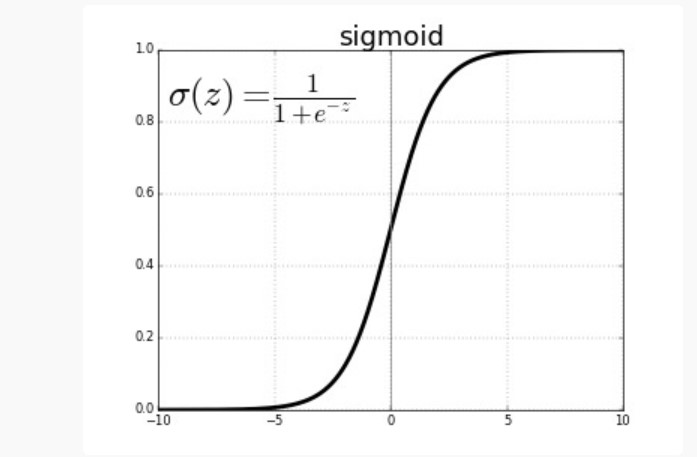

In [95]:
from sklearn.linear_model import LogisticRegression

In [96]:
model = LogisticRegression(solver='liblinear')

In [97]:
model.fit(X_sm,y_sm)

LogisticRegression(solver='liblinear')

In [ ]:
X_train = train_inputs[req_col + encoded_cols]
X_test = test_inputs[req_col + encoded_cols]

In [ ]:
train_preds = model.predict(X_train)

In [98]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(train_targets, train_preds)

0.8968244645444222

In [99]:
test_preds = model.predict(test_inputs)

In [100]:
accuracy_score(test_targets, test_preds)

0.7362386368827372

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 89.68%


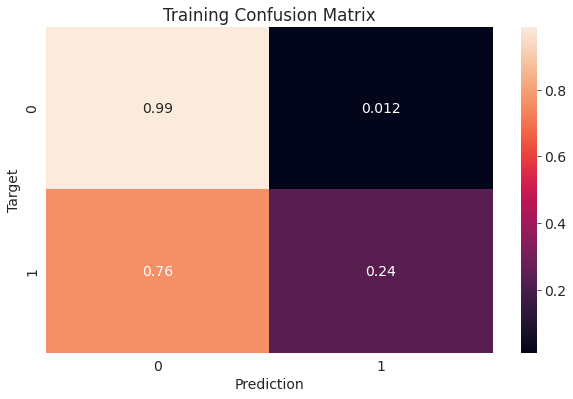

In [ ]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Accuracy: 89.38%


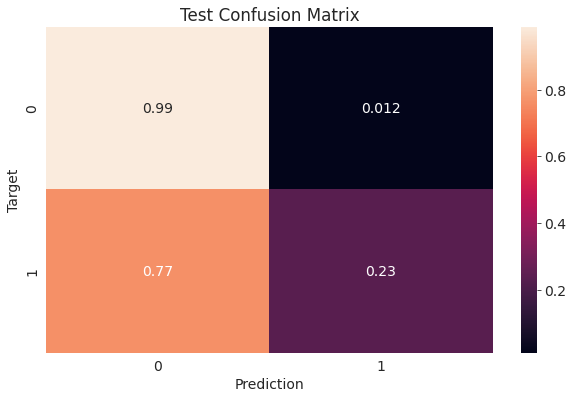

In [ ]:
test_preds = predict_and_plot(X_test, test_targets, 'Test')

In [ ]:
test_targets.value_counts()

0.0    12745
1.0     1849
Name: IsBadBuy, dtype: int64

always predicting no to test data will give 87.33%  accuracy .. 
and this logistic regression model makes a accuracy of 89.28%

## Model - Decision tree

In [ ]:
X_train = train_inputs[req_col + encoded_cols]
X_test = test_inputs[req_col + encoded_cols]

In [ ]:
X_train

,VehYear,VehicleAge,VehOdo,VehBCost,IsOnlineSale,WarrantyCost,pricediff_before,pricediff_after,Auction_ADESA,Auction_MANHEIM,Auction_OTHER,Make_ACURA,Make_BUICK,Make_CADILLAC,Make_CHEVROLET,Make_CHRYSLER,Make_DODGE,Make_FORD,Make_GMC,Make_HONDA,Make_HUMMER,Make_HYUNDAI,Make_INFINITI,Make_ISUZU,Make_JEEP,Make_KIA,Make_LEXUS,Make_LINCOLN,Make_MAZDA,Make_MERCURY,Make_MINI,Make_MITSUBISHI,Make_NISSAN,Make_OLDSMOBILE,Make_PLYMOUTH,Make_PONTIAC,Make_SATURN,Make_SCION,Make_SUBARU,Make_SUZUKI,Make_TOYOTA,Make_TOYOTA SCION,Make_VOLKSWAGEN,Make_VOLVO,Color_BEIGE,Color_BLACK,Color_BLUE,Color_BROWN,Color_GOLD,Color_GREEN,Color_GREY,Color_MAROON,Color_NOT AVAIL,Color_ORANGE,Color_OTHER,Color_PURPLE,Color_RED,Color_SILVER,Color_WHITE,Color_YELLOW,Transmission_AUTO,Transmission_MANUAL,WheelType_Alloy,WheelType_Covers,WheelType_Special,WheelType_other,Nationality_AMERICAN,Nationality_ASIAN,Nationality_OTHER,Size_COMPACT,Size_CROSSOVER,Size_LARGE,Size_LARGE SUV,Size_LARGE TRUCK,Size_MEDIUM,Size_MEDIUM SUV,Size_SMALL SUV,Size_SMALL TRUCK,Size_SPECIALTY,Size_SPORTS,Size_VAN,PRIMEUNIT_NO,PRIMEUNIT_YES,PRIMEUNIT_other,AUCGUART_GREEN,AUCGUART_RED,AUCGUART_other,VNST_AL,VNST_AR,VNST_AZ,VNST_CA,VNST_CO,VNST_FL,VNST_GA,VNST_IA,VNST_ID,VNST_IL,VNST_IN,VNST_KY,VNST_LA,VNST_MA,VNST_MD,VNST_MI,VNST_MN,VNST_MO,VNST_MS,VNST_NC,VNST_NE,VNST_NH,VNST_NJ,VNST_NM,VNST_NV,VNST_NY,VNST_OH,VNST_OK,VNST_OR,VNST_PA,VNST_SC,VNST_TN,VNST_TX,VNST_UT,VNST_VA,VNST_WA,VNST_WV
7102,0.333333,0.555556,0.541265,0.183844,0.0,0.107021,0.862114,0.851733,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59294,0.444444,0.444444,0.742551,0.118853,0.0,0.055571,0.559436,0.595200,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23863,0.555556,0.444444,0.596589,0.177399,0.0,0.048465,0.590609,0.580400,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11645,0.555556,0.444444,0.453567,0.131939,0.0,0.088687,0.598888,0.541733,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26778,0.777778,0.222222,0.627115,0.214415,0.0,0.015208,0.416246,0.452267,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.

In [101]:
from sklearn.tree import DecisionTreeClassifier

In [102]:
model = DecisionTreeClassifier(random_state=21)

In [103]:
%%time

model.fit(X_sm, y_sm)

CPU times: user 2.66 s, sys: 0 ns, total: 2.66 s
Wall time: 2.66 s


DecisionTreeClassifier(random_state=21)

## Testing

In [104]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
train_preds = model.predict(X_train)

In [ ]:
pd.value_counts(train_preds)

0.0    51249
1.0     7126
dtype: int64

In [ ]:
train_probs = model.predict_proba(X_train)
accuracy_score(train_targets, train_preds)

1.0

In [105]:
model.score(test_inputs, test_targets)

0.8188296560230232

In [ ]:
test_targets.value_counts() / len(test_targets)

0.0    0.873304
1.0    0.126696
Name: IsBadBuy, dtype: float64

In [106]:
model.tree_.max_depth

44

### Tuning_max_deapth

In [108]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_sm,y_sm)
    train_acc = 1 - model.score(X_sm, y_sm)
    test_acc = 1 - model.score(test_inputs, test_targets)
    return {'Max Depth': md, 'Training Error': train_acc, 'Testing Error': test_acc}

In [109]:
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 26)])

In [110]:
errors_df

,Max Depth,Training Error,Testing Error
0,1,0.373032,0.106711
1,2,0.306070,0.363026
2,3,0.305646,0.360696
3,4,0.220599,0.233109
4,5,0.205704,0.231602
5,6,0.174363,0.159837
6,7,0.168220,0.171760
7,8,0.153514,0.123064
8,9,0.146802,0.126673
9,10,0.137916,0.112101


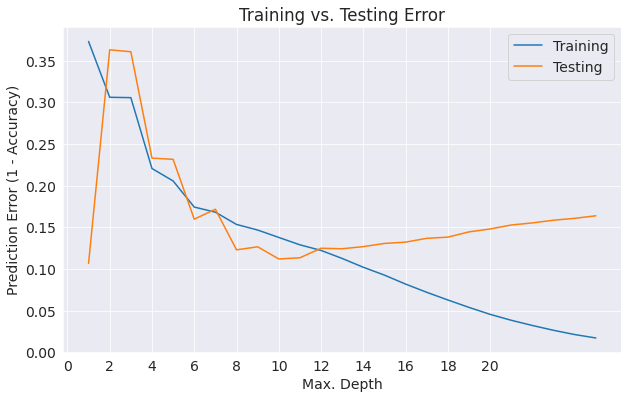

In [111]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Testing Error'])
plt.title('Training vs. Testing Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Testing']);

* From above graph we choose max_deapth criterion for the decision tree as we increase deapth .. the model is over fitting .. to avoid over fitting we take a max deapth of 10

In [112]:
model = DecisionTreeClassifier(max_depth=10, random_state=38)

In [113]:
model.fit(X_sm,y_sm)
train_preds = model.predict(X_sm)

In [114]:
train_probs = model.predict_proba(X_sm)
accuracy_score(y_sm, train_preds)

0.8620835749007715

In [115]:
model.score(test_inputs, test_targets)

0.8877164131378192

In [ ]:
model1= DecisionTreeClassifier(min_samples_split=)

In [116]:
from sklearn.model_selection import GridSearchCV

In [117]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"],
}

In [118]:
model=DecisionTreeClassifier(random_state=42)

In [119]:
model.fit(X_sm,y_sm)

DecisionTreeClassifier(random_state=42)

In [120]:
grid_search = GridSearchCV(estimator=model,
                           param_grid=params, n_jobs=-1, verbose=1, scoring = "accuracy")

In [122]:
grid_search.fit(X_sm, y_sm)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [123]:
score_df = pd.DataFrame(grid_search.cv_results_)

In [ ]:
score_df

entropy , max_depth=5 , min_samples_leaf = 50 

In [125]:
model = DecisionTreeClassifier(max_depth=5,criterion='gini',min_samples_split=20,random_state=38)

In [126]:
model.fit(X_sm,y_sm)

DecisionTreeClassifier(max_depth=5, min_samples_split=20, random_state=38)

In [127]:
model.score(test_inputs,test_targets)

0.7683979717692202

In [ ]:
model = DecisionTreeClassifier(max_depth=5,criterion='entropy',min_samples_split=50,random_state=42)

In [ ]:
model.fit(X_train,train_targets)

In [ ]:
model.score(X_test,test_targets)

In [ ]:
score_df[score_df['rank_test_score']<=10]

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/veerendra0201/ml-project


'https://jovian.ai/veerendra0201/ml-project'

for a clear view .. lets draw the confusion matrix for this model

In [ ]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

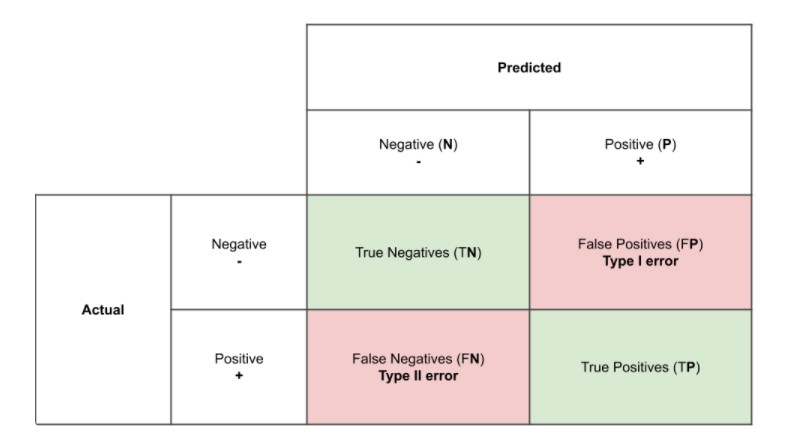

Accuracy: 90.79%


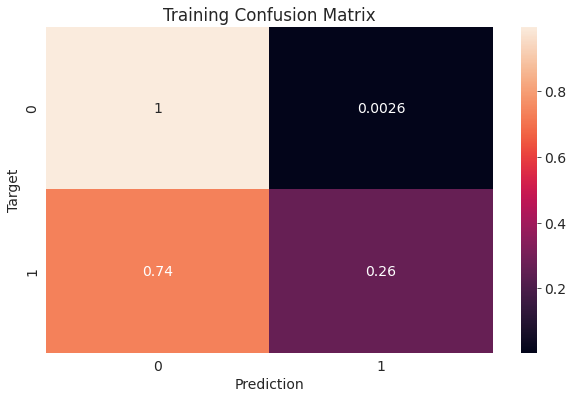

In [ ]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Accuracy: 89.74%


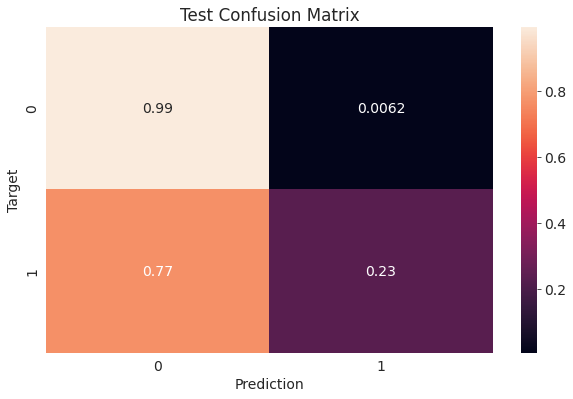

In [ ]:
test_preds = predict_and_plot(X_test, test_targets, 'Test')

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/veerendra0201/ml-project


'https://jovian.ai/veerendra0201/ml-project'

In [ ]:
max_depth=[1,5,10,15,20,23,25,30]
Training_accuracy=[0.8779271948608137,0.8792291220556745,0.902492505353319,0.907340471092077,0.9210107066381157,0.9348351177730193,0.9456959314775161,0.979100642398287]
Testing_accuracy =[ 0.8733040975743456,0.874743045087022,0.8972180348088256,0.898656982321502,0.8988625462518843,0.8985199397012471,0.8987255036316294,0.898656982321502]

Test_error = []
for i in Testing_accuracy:
    Test_error.append(1-i) 

data={"depth":max_depth,
      "Training_accuracy":Training_accuracy,
      "Testing_accuracy":Testing_accuracy,
      "Test_error": Test_error}

error_df=pd.DataFrame(data)
print(error_df)

   depth  Training_accuracy  Testing_accuracy  Test_error
0      1           0.877927          0.873304    0.126696
1      5           0.879229          0.874743    0.125257
2     10           0.902493          0.897218    0.102782
3     15           0.907340          0.898657    0.101343
4     20           0.921011          0.898863    0.101137
5     23           0.934835          0.898520    0.101480
6     25           0.945696          0.898726    0.101274
7     30           0.979101          0.898657    0.101343


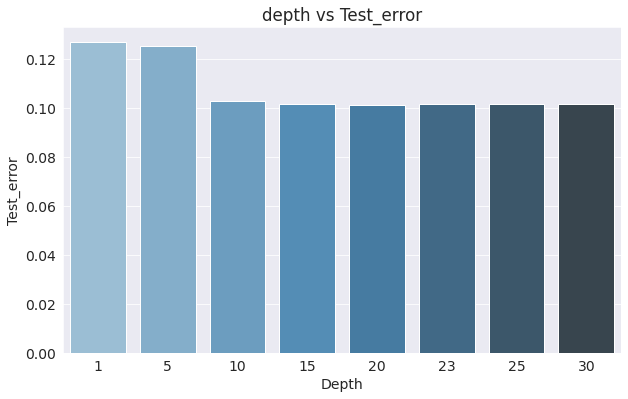

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (10,6))
plt.title('depth vs Test_error')
plt.xlabel('Depth')
plt.ylabel('Test_error')
sns.barplot(y = Test_error, x = max_depth,palette = 'Blues_d', data = error_df);

**Now we check some other model in search of better accuracy.**

## Model - Random Forest

In [128]:
from sklearn.ensemble import RandomForestClassifier

In [129]:
model_RF = RandomForestClassifier(n_jobs=-1, random_state=42)

In [130]:
model_RF.fit(X_sm, y_sm)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [131]:
model_RF.score(X_sm, y_sm)

1.0

In [132]:
model_RF.score(test_inputs, test_targets)

0.8902745420492439

In [ ]:
def predict_and_plot(inputs, targets, name=''):
    preds = model_RF.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 89.84%


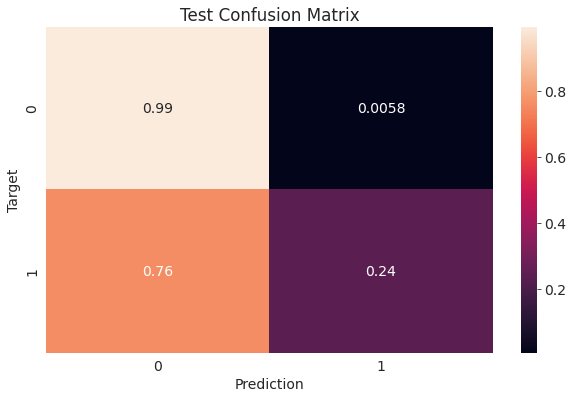

In [ ]:
test_preds = predict_and_plot(X_test, test_targets, 'Test')

In [ ]:
train_probs = model_RF.predict_proba(X_train)

In [ ]:
train_probs

array([[0.97, 0.03],
       [0.91, 0.09],
       [1.  , 0.  ],
       ...,
       [0.99, 0.01],
       [0.99, 0.01],
       [1.  , 0.  ]])

### Tuning Random Forest tree-count

In [135]:
X_train=X_sm.copy()
train_targets = y_sm.copy()
X_test = test_inputs.copy()

In [136]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, train_targets)

In [137]:
base_train_acc = base_model.score(X_train, train_targets)
base_test_acc = base_model.score(X_test, test_targets)

In [138]:
base_accs = base_train_acc, base_test_acc
base_accs

(1.0, 0.8902745420492439)

*Just a base model gave pretty good predictions ... so lets try to tune one or two parameters*

In [139]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {
    'max_depth': [ 3,4,10],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'n_estimators' :[100,150,200,250]
}

In [ ]:
model=RandomForestClassifier(random_state=42)

In [ ]:
random_search = RandomizedSearchCV(estimator=model,param_distributions=params,n_jobs=-1,verbose=1,scoring="accuracy")

In [ ]:
grid_search = GridSearchCV(estimator=model, 
                           param_grid=params, cv=4,
                            n_jobs=-1, verbose=1, scoring = "accuracy")

In [ ]:
random_search.fit(X_train,train_targets)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: ignored

In [ ]:
grid_search.fit(X_train,train_targets)

In [ ]:
ran_df=pd.DataFrame(random_search.cv_results_)

In [ ]:
score_df = pd.DataFrame(grid_search.cv_results_)

In [ ]:
score_df[score_df['rank_test_score']<=10]

In [ ]:
ran_df

In [ ]:
jovia

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/veerendra0201/ml-project


'https://jovian.ai/veerendra0201/ml-project'

In [ ]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 89.90%


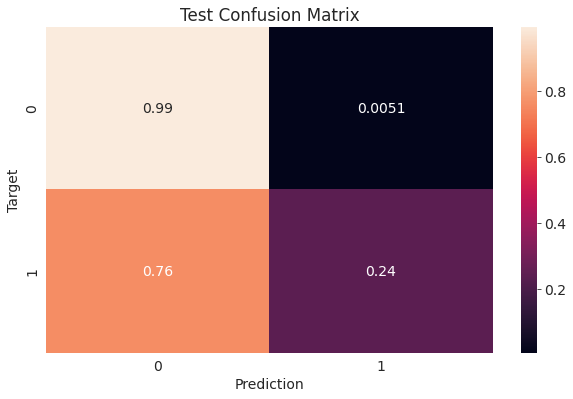

In [ ]:
test_preds = predict_and_plot(X_test, test_targets, 'Test')

In [140]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=300)

In [141]:
model.fit(X_train, train_targets)
model.score(X_train, train_targets), model.score(X_test, test_targets)

(1.0, 0.8910967977707733)

In [142]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=400)

In [143]:
model.fit(X_train, train_targets)
model.score(X_train, train_targets), model.score(X_test, test_targets)

(1.0, 0.8913708830112832)

**The model made great predictions with n_estimators = 200**

## Tuning max deapth

In [144]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=200)

In [147]:
def test_params(md):
    model = RandomForestClassifier(random_state=42, n_jobs=-1,n_estimators=200, max_depth = md).fit(X_train, train_targets)
    return {'Max Depth': md, 'Training Error': model.score(X_train, train_targets), 'Testing Error': model.score(X_test, test_targets)}

In [151]:
errors2_df = pd.DataFrame([test_params(md) for md in range(26, 36)])

In [157]:
errors2_df

,Max Depth,Training Error,Testing Error
0,26,0.994269,0.884062
1,27,0.996856,0.885615
2,28,0.998060,0.886026
3,29,0.998963,0.887899
4,30,0.999431,0.888493
5,31,0.999688,0.888813
6,32,0.999900,0.888539
7,33,0.999967,0.888584
8,34,0.999967,0.889315
9,35,0.999989,0.889635


In [149]:
errors_df

,Max Depth,Training Error,Testing Error
0,2,0.714311,0.653465
1,3,0.722930,0.671143
2,4,0.730344,0.673839
3,5,0.742162,0.693892
4,6,0.755318,0.707049
5,7,0.775487,0.736284
6,8,0.794218,0.754100
7,9,0.811655,0.765748
8,10,0.828915,0.786168
9,11,0.845939,0.801197


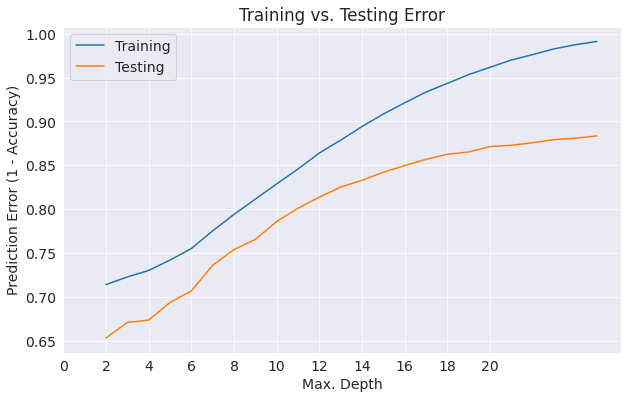

In [150]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Testing Error'])
plt.title('Training vs. Testing Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Testing']);

In [ ]:
test_params(max_depth=1)

(0.8779271948608137, 0.8733040975743456)

In [ ]:
test_params(max_depth=5)

(0.8792291220556745, 0.874743045087022)

In [ ]:
test_params(max_depth=10)

(0.902492505353319, 0.8972180348088256)

In [ ]:
test_params(max_depth=15)

(0.907340471092077, 0.898656982321502)

In [ ]:
test_params(max_depth=20)

(0.9210107066381157, 0.8988625462518843)

In [ ]:
test_params(max_depth=25)

(0.9456959314775161, 0.8987255036316294)

In [ ]:
test_params(max_depth=30)

(0.979100642398287, 0.898656982321502)

In [ ]:
test_params(max_depth=23)

(0.9348351177730193, 0.8985199397012471)

**The model with 200 estimators and max deapth of 20 gives good predictions .. but less than we can achive without tuning deapth and 200 estimators**

In [ ]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=200)

In [ ]:
model.fit(X_train, train_targets)
model.score(X_train, train_targets), model.score(X_test, test_targets)

(1.0, 0.8989995888721393)

**observation till now , test accuracy with diff models**

*decision tree with 10 max deapth - 0.894957*

*random forest with 200 estimators - 0.8989995888721393*

*random forest with 200 estimators and 20 max_deapth - 0.8988625462518843*


In [ ]:
n_estimators=[10,50,100,200,300]
Training_accuracy=[0.9842912205567452,0.9991092077087794,0.999948608137045,1.0,1.0,]
Testing_accuracy =[0.8937234479923256,0.897286556118953,0.8983828970809922,0.8989995888721393,0.8985199397012471]
data={"estimators":n_estimators,
      "Training_accuracy":Training_accuracy,
      "Testing_accuracy":Testing_accuracy}
error_df=pd.DataFrame(data)
print(error_df)

   estimators  Training_accuracy  Testing_accuracy
0          10           0.984291          0.893723
1          50           0.999109          0.897287
2         100           0.999949          0.898383
3         200           1.000000          0.899000
4         300           1.000000          0.898520


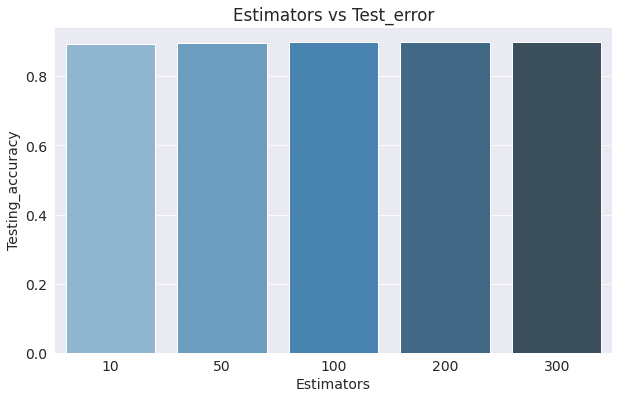

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (10,6))
plt.title('Estimators vs Test_error')
plt.xlabel('Estimators')
plt.ylabel('Testing_accuracy')
sns.barplot(y = Testing_accuracy, x =n_estimators, palette = 'Blues_d', data = error_df);

the accuracy doesn't change after 200 estimators .. so we pick 200 estimators 

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/veerendra0201/ml-project


'https://jovian.ai/veerendra0201/ml-project'

lets pick  another model and search for better accuracy

####K-Nearest Neighbours

In [152]:
from sklearn.neighbors import KNeighborsClassifier

In [153]:
model=KNeighborsClassifier(n_neighbors=5)

In [154]:
model.fit(X_train,train_targets)

KNeighborsClassifier()

In [155]:
model.score(X_test,test_targets)

0.63487277876753

In [156]:
def nearest_neighbour_error(nei):
    model = KNeighborsClassifier(n_neighbors=nei)
    model.fit(X_train, train_targets)
    train_acc = 1 - model.score(X_train, train_targets)
    test_acc = 1 - model.score(X_test, test_targets)
    return {'neighbours': nei, 'Training Error': train_acc, 'Testing Error': test_acc}

In [158]:
errors_df = pd.DataFrame([nearest_neighbour_error(nei) for nei in range(5,26)]) 

In [159]:
errors_df

,neighbours,Training Error,Testing Error
0,5,0.136010,0.365127
1,6,0.128384,0.331232
2,7,0.168410,0.394135
3,8,0.159646,0.364259
4,9,0.190797,0.408296
5,10,0.182781,0.380659
6,11,0.208201,0.425380
7,12,0.199706,0.396373
8,13,0.221045,0.434060
9,14,0.213230,0.408570


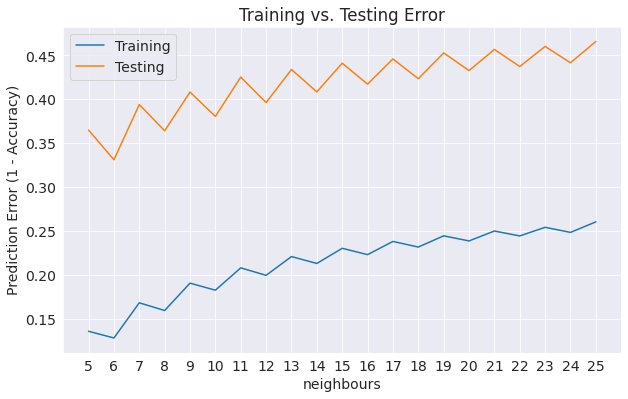

In [161]:
plt.figure()
plt.plot(errors_df['neighbours'], errors_df['Training Error'])
plt.plot(errors_df["neighbours"], errors_df['Testing Error'])
plt.title('Training vs. Testing Error')
plt.xticks(range(5,26))
plt.xlabel('neighbours')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Testing']);

taking a look at above graph .. we choose a neighbour of count 12

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/veerendra0201/ml-project


'https://jovian.ai/veerendra0201/ml-project'

In [ ]:
model=KNeighborsClassifier(n_neighbors=12)

In [ ]:
model.fit(X_train, train_targets)

KNeighborsClassifier(n_neighbors=12)

In [ ]:
model.score(X_test, test_targets)

0.8887899136631492

In [ ]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 88.88%


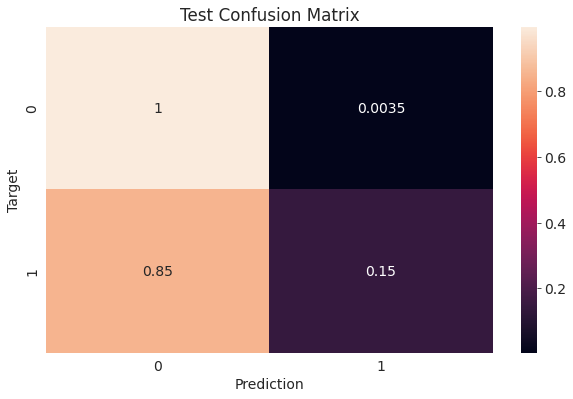

In [ ]:
test_preds = predict_and_plot(X_test, test_targets, 'Test')

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/veerendra0201/ml-project


'https://jovian.ai/veerendra0201/ml-project'

comparing the accuracies and verifying confusion marix .. we get to a conclusion based on our 